In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import *
import skimage.filters

import sys
sys.path.append('../utilities')
from utilities import *
from mask_generator import *
from utilities import *
from synthetic_image import *
from mask_generator import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
import multiprocessing
num_cores = multiprocessing.cpu_count()
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
client = Client()

import glob
import random
import os

%matplotlib widget

distributed.diskutils - INFO - Found stale lock file and directory '/home/sommer/Documents/IR/CLOUD_DETECTION/infrared-cloud-detection/dask-worker-space/worker-pd2rhl1p', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sommer/Documents/IR/CLOUD_DETECTION/infrared-cloud-detection/dask-worker-space/worker-fssduh4y', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sommer/Documents/IR/CLOUD_DETECTION/infrared-cloud-detection/dask-worker-space/worker-g911e2vl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/sommer/Documents/IR/CLOUD_DETECTION/infrared-cloud-detection/dask-worker-space/worker-uj4oodoz', purging


#### **Open FITS image with astropy and get shape**

In [2]:
image = fits.getdata('fits_samples/clear_sky_sample.fits')


#### **Simulate synthetic clear sky image with noise**

In [47]:
syn, noise_syn = simulate_clear_sky_image(start=600, stop=650, width=640, height=512, is_horizontal=True, bias_level=200, read_noise_level = 2, fpn_level=5, col_values = 5, bad_pixel_columns = 400, sky_noise_level = 10, return_original = True, augment_synthetic = False, apply_narcissus_effect = True, radius=160, center_x=320, center_y=256, smoothness=70, nar_intensity=0.05, seed=1, write_to_fits = False, index = 0)

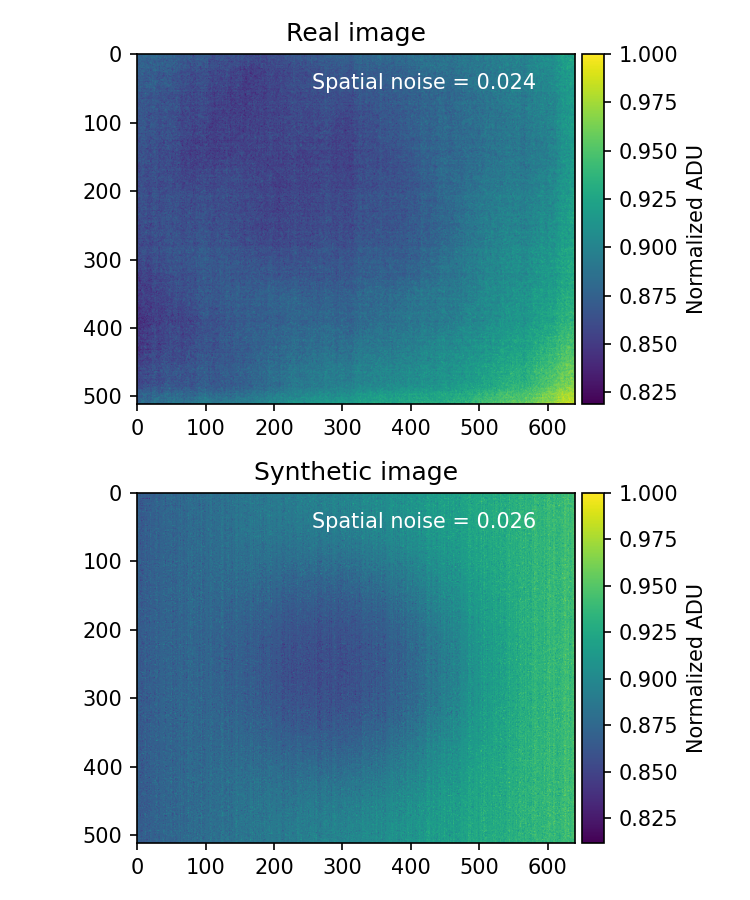

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6), dpi=150)
ax1 = axes[0]
ax1.set_title('Real image')
im1 = ax1.imshow(image/np.max(image), cmap='viridis')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax, orientation='vertical')
cbar1.ax.set_ylabel('Normalized ADU')
ax1.text(0.4, 0.9, 'Spatial noise = {:.3f}'.format(np.std(image/np.max(image))), color='white', fontsize='medium', transform=ax1.transAxes)


ax2 = axes[1]
ax2.set_title('Synthetic image')
im2 = ax2.imshow(noise_syn/np.max(noise_syn), cmap='viridis')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar2.ax.set_ylabel('Normalized ADU')
ax2.text(0.4, 0.9, 'Spatial noise = {:.3f}'.format(np.std(noise_syn/np.max(noise_syn))), color='white', fontsize='medium', transform=ax2.transAxes)

plt.tight_layout()
plt.savefig('paper/figures/synthetic_clear_sky_image.pdf', dpi=600)
plt.show()

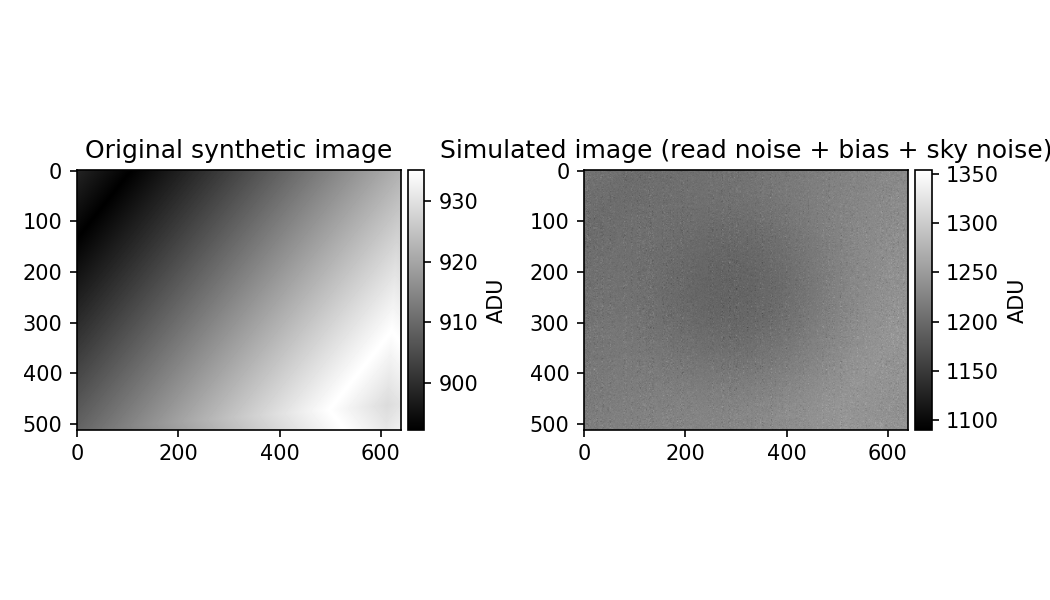

In [4]:
plot_synthetic_noisy_images(syn=syn, noisy=noise_syn, cmap='gray')

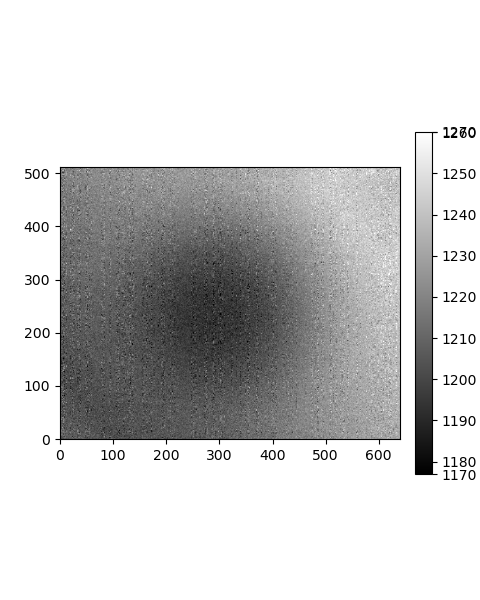

In [5]:
show_image(noise_syn, cmap='gray', figsize=(6,4))

In [6]:
np.std(noise_syn)

17.90239354528153

In [7]:
np.std(image)

16.71885140709978

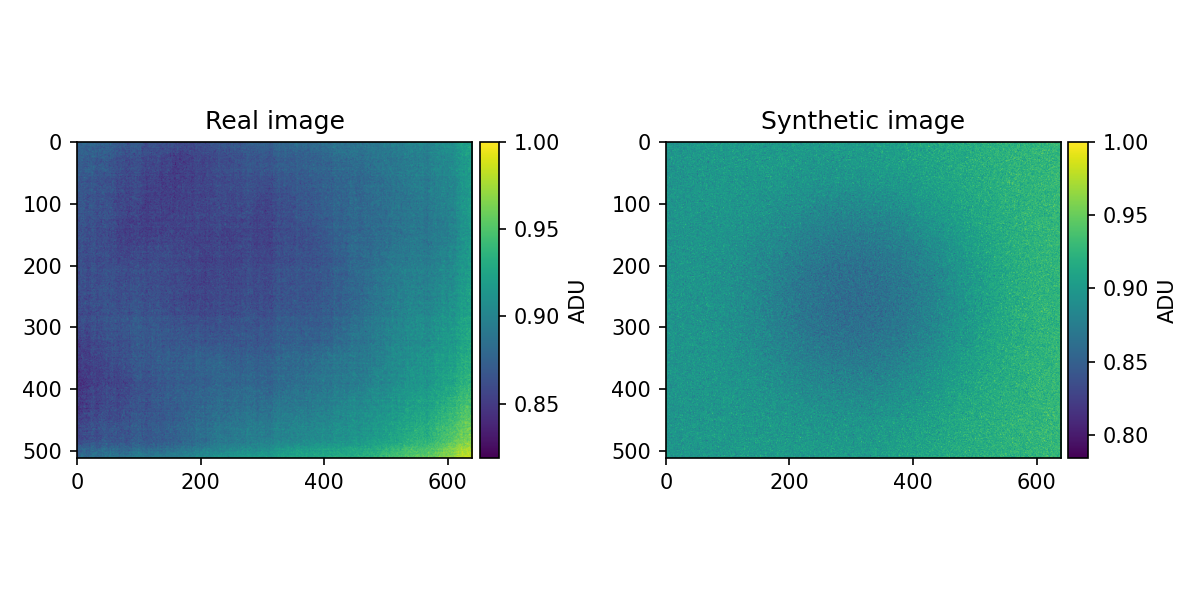

#### **Simulate synthetic images**

In [8]:
N = 2000
with parallel_backend('threading', n_jobs=num_cores):
    l_sim = Parallel(verbose=5)(delayed(simulate_clear_sky_image)(start=600, stop=650, width=640, height=512, is_horizontal=True,
    bias_level=np.random.randint(low=200, high=400, size=1)[0], read_noise_level = 5, fpn_level=np.random.randint(low=3, high=10, size=1)[0], bad_pixel_columns = np.random.randint(low=80, high=200, size=1)[0], sky_noise_level = np.random.randint(low=5, high=15, size=1)[0], return_original = False, augment_synthetic = True, apply_narcissus_effect = True, radius=np.random.randint(low=150, high=170, size=1)[0], center_x=np.random.randint(low=300, high=340, size=1)[0], center_y=np.random.randint(low=236, high=276, size=1)[0], smoothness=np.random.randint(low=70, high=90, size=1)[0], nar_intensity=np.random.uniform(low=0.02, high=0.04, size=1)[0], seed=None, write_to_fits = True, index = i) for i in range(0, N))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   39.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:  4.8min finished
